In [1]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

从mask后的数据计算每月的情况，将13年的4-8月绘制热图比较<br>

此处简单地做了个减法

remains:绘制更多统计量的

In [2]:
# 读取数据
# year = "2006"
# 注释掉的是原始数据，此后的是进行了mask之后的数据
# dir_vr = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/pre/" + "daily_pre_03-15.nc"
dir_vr = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_mean_vr_03-15.nc"
ds_vr_mean = xr.open_dataset(dir_vr)

dir_vr = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_max_vr_03-15.nc"
ds_vr_max = xr.open_dataset(dir_vr)

dir_vr = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_min_vr_03-15.nc"
ds_vr_min = xr.open_dataset(dir_vr)

dir_rcm = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_mean_rcm_03-15.nc"
ds_rcm_mean = xr.open_dataset(dir_rcm)

dir_rcm = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_max_rcm_03-15.nc"
ds_rcm_max = xr.open_dataset(dir_rcm)

dir_rcm = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_min_rcm_03-15.nc"
ds_rcm_min = xr.open_dataset(dir_rcm)


obs_cn051_tm  = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/ordata/" +  "sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
ds_cn051_mean = xr.open_dataset(obs_cn051_tm)
obs_cn051_tmax  = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/ordata/" +  "sel_CN05.1_Tmax_1961_2018_daily_025x025.nc"
ds_cn051_max = xr.open_dataset(obs_cn051_tmax)
obs_cn051_tmin  = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/ordata/" +  "sel_CN05.1_Tmin_1961_2018_daily_025x025.nc"
ds_cn051_min = xr.open_dataset(obs_cn051_tmin)

vr_raw     = ds_vr_mean['t2m'] - 273.15
rcm_raw    = ds_rcm_mean['t2m'] - 273.15
cn051_raw  = ds_cn051_mean['tm']



计算月平均

In [3]:
# groupby到每个月，计算其上的空间平均
cn051_monofyears = cn051_raw.groupby(cn051_raw.time.dt.month).mean()
vr_monofyears = vr_raw.groupby(vr_raw.Time.dt.month).mean()
rcm_monofyears = rcm_raw.groupby(rcm_raw.Time.dt.month).mean()


In [4]:
# 计算整个 4-8 月的平均
rcm_timemean = rcm_raw.mean(dim="Time")
vr_timemean  = vr_raw.mean(dim="Time")
cn051_timemean = cn051_raw.mean(dim="time")

In [5]:
# 将 4-8 月的平均添加 months 维度，添加到每个月的group结果之下
rcm_monofyears = xr.concat([rcm_monofyears, rcm_timemean.assign_coords({'month' : 'all'}).expand_dims('month')], dim='month', coords="minimal")

vr_monofyears = xr.concat([vr_monofyears, vr_timemean.assign_coords({'month' : 'all'}).expand_dims('month')], dim='month', coords="minimal")

cn051_monofyears = xr.concat([cn051_monofyears, cn051_timemean.assign_coords({'month' : 'all'}).expand_dims('month')], dim='month', coords="minimal")
# rcm_monofyears.month

In [6]:
# 进行核密度估计
# 尝试用直线 + 虚线绘制同一数据的核密度估计和原本的经验分布直方图
from sklearn.neighbors import KernelDensity
num_bins =  100 # bins for pdf
# 存储的字典，字典包含三个变量的列表，列表中即使4-8五个月
histogram_5months = {}
bins_5months      = {}
kde_bins_5months  = {}
kde_5months       = {}
#bins
sel_bins = np.linspace(-20,40,600)
# loop data
pre_vars          = {"cn051":cn051_monofyears, "vr":vr_monofyears, "rcm":rcm_monofyears}

for i in pre_vars: # loop months for i
    histogram_5months[i] = []
    bins_5months[i] = [] 
    kde_5months[i] = []
    kde_bins_5months[i] = []
    for mon in range(0,6):
        temp_1d = pre_vars[i][mon].values.ravel() # convert to 1d
        temp_1d = temp_1d[~np.isnan(temp_1d)] # remove nan

        histogram, bins = np.histogram(temp_1d, bins=num_bins, density=True) # count pdf
        bin_centers = 0.5*(bins[1:] + bins[:-1]) #

        histogram_5months[i].append(histogram) # appends histogram
        bins_5months[i].append(bin_centers) # append bins

        kernel_test = KernelDensity(bandwidth=2., algorithm='auto', kernel='linear', metric='euclidean').fit(temp_1d.reshape(-1, 1))
        log_dens    = kernel_test.score_samples(sel_bins.reshape(-1, 1))
        exp_dens    = np.exp(log_dens)
        # exp_dens    = log_dens

        kde_5months[i].append(exp_dens)
        kde_bins_5months[i].append(sel_bins)



<ipython-input-37-3ff2d54bc99a>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_ind.set_yticklabels(['{:.1f}%'.format(x*100) for x in ax_ind.get_yticks()])
<ipython-input-37-3ff2d54bc99a>:69: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "set_facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("./output_pic/pdf_kde_months.png", set_facecolor = "white", dpi = 300)


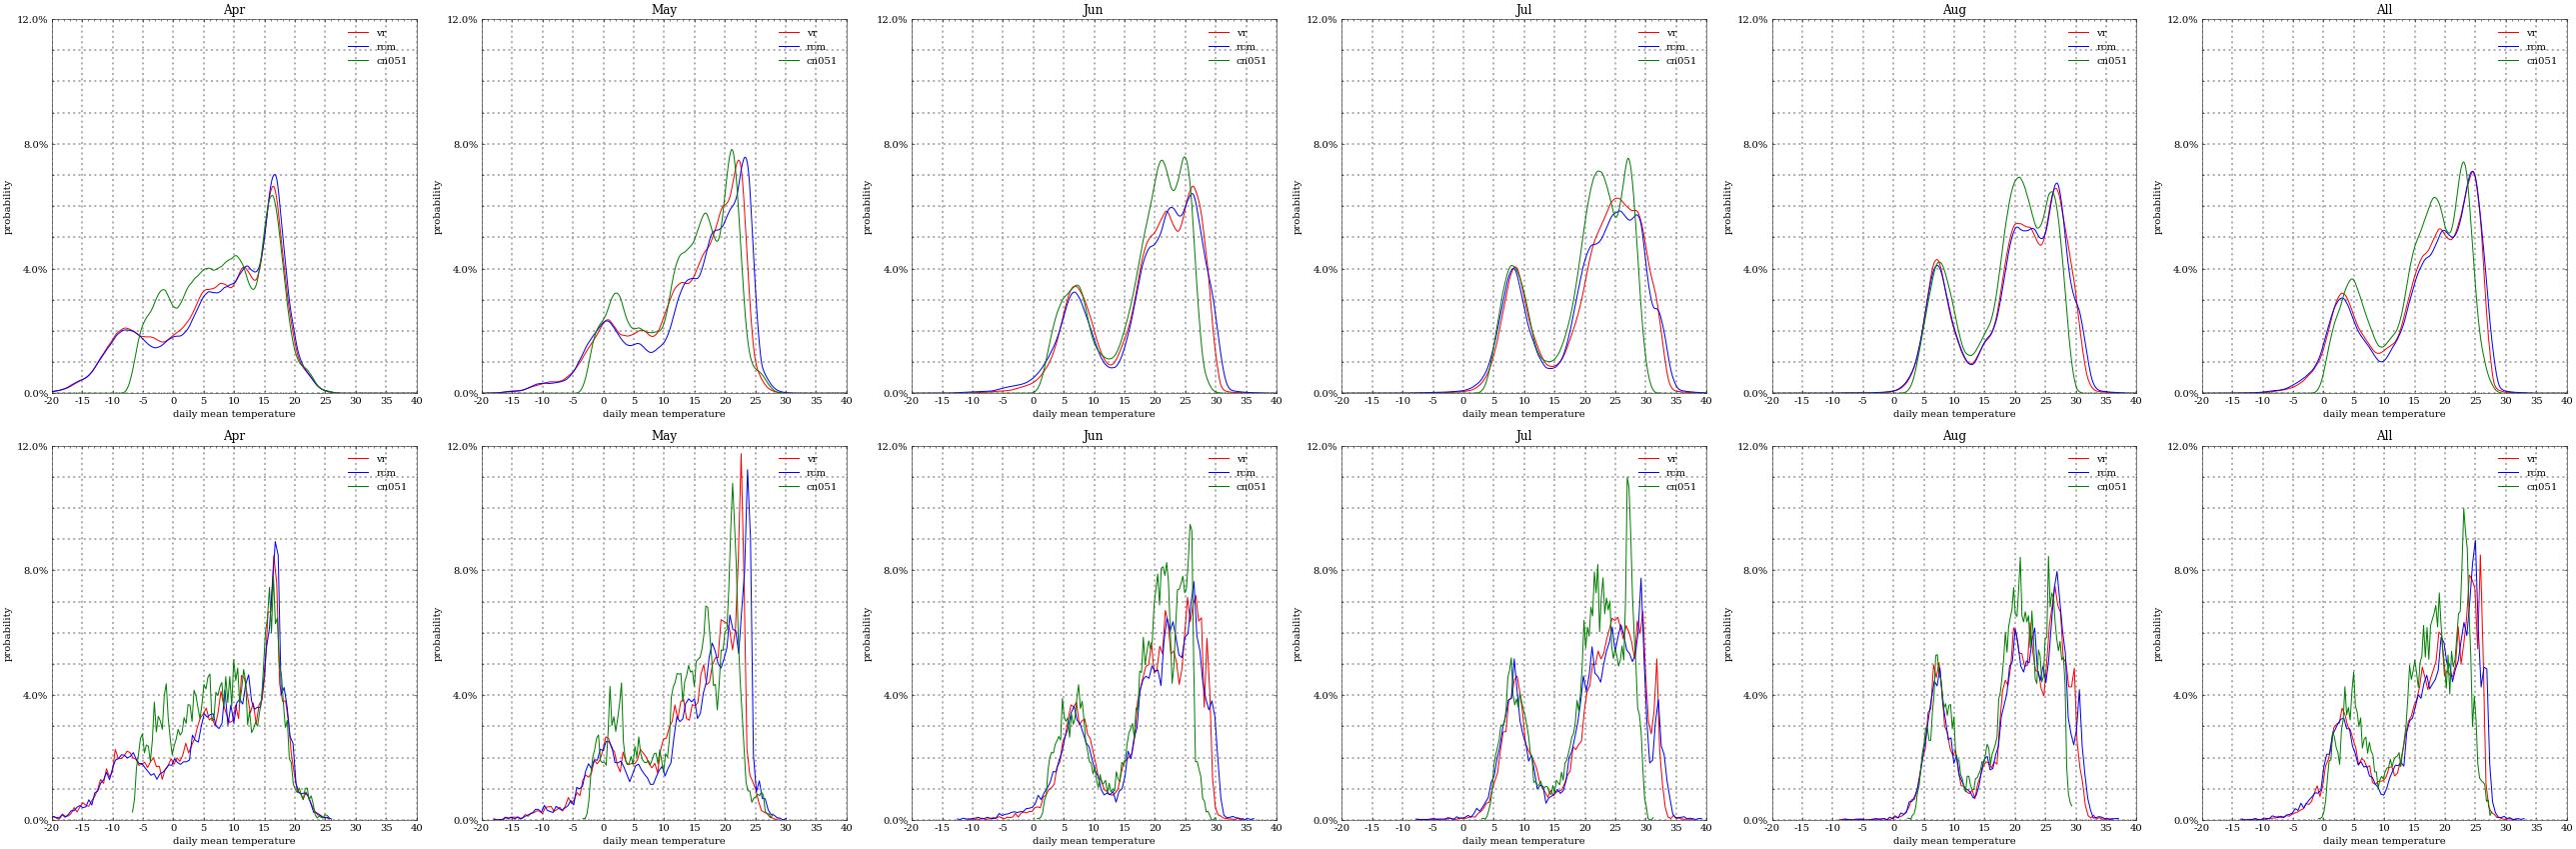

In [37]:


# 进行绘图
from matplotlib import pyplot as plt

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import matplotlib.ticker as mtick

plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展
fig,ax = plt.subplots(2,6,figsize=(36,12))

fig.patch.set_facecolor('white')
mon_ind = 0
mon_name = ['Apr','May','Jun','Jul','Aug','All']

# 循环绘制所有月份的 核密度估计 PDF直方图
for i in range(0,6):
    model_type = 'vr'
    ax[0,i].plot(kde_bins_5months[model_type][i], kde_5months[model_type][i],'-r', label=model_type)
    ax[1,i].plot(bins_5months[model_type][i], histogram_5months[model_type][i], '-r', label=model_type)
    model_type = 'rcm'
    ax[0,i].plot(kde_bins_5months[model_type][i], kde_5months[model_type][i],'-b', label=model_type)
    ax[1,i].plot(bins_5months[model_type][i], histogram_5months[model_type][i], '-b', label=model_type)
    model_type = 'cn051'
    ax[0,i].plot(kde_bins_5months[model_type][i], kde_5months[model_type][i],'-g', label=model_type)
    ax[1,i].plot(bins_5months[model_type][i], histogram_5months[model_type][i], '-g', label=model_type)

    ax[0,i].set_title(mon_name[i])
    ax[1,i].set_title(mon_name[i])

# 循环设置所有坐标轴以及范围

for i, ax_ind in enumerate(ax.flat):
   
    #  Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax_ind.set_xlim(-20,40)
    ax_ind.set_ylim(0,0.12)
    # xticks
    ax_ind.xaxis.set_major_locator(MultipleLocator(5))
    ax_ind.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # For the minor ticks, use no labels; default NullFormatter.
    ax_ind.xaxis.set_minor_locator(MultipleLocator(1))

    #yticks
    # ax_ind.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax_ind.yaxis.set_major_locator(MultipleLocator(0.04))
    # ax_ind.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_ind.yaxis.set_minor_locator(MultipleLocator(0.01))
    ax_ind.set_yticklabels(['{:.1f}%'.format(x*100) for x in ax_ind.get_yticks()]) 

    ax_ind.xaxis.grid(linestyle=":", which="major", linewidth=2.)
    # ax_ind.xaxis.grid(linestyle=":", which="minor")
    ax_ind.yaxis.grid(linestyle=":", which="major", linewidth=2.)
    ax_ind.yaxis.grid(linestyle=":", which="minor", linewidth=2.)

    ax_ind.set_xlabel('daily mean temperature')
    ax_ind.set_ylabel('probability')
    # ax_ind.set_title(mon_name[int(i/2)])
    # ax[0].set_xticks(np.linspace(0,15,16), minor=True)
    # ax[0].xaxis.set_minor_locator()# = np.linspace(0,15,16))
    ax_ind.legend()


# plt.show()
# plt.savefig("./output_pic/pdf_kde_months.png")
plt.tight_layout()
plt.savefig("./output_pic/pdf_kde_months.png", set_facecolor = "white", dpi = 300)